In [1]:
from pyspark.sql import functions as F
# from helper import run_forecast, aggregate_to_granularity, build_features, train_test_split

from helper import (
    aggregate_to_granularity, assert_unique_series_rows, build_features,
    train_test_split, model_factory, assemble_global_pipeline, fit_global_model, predict_global,
    compute_metrics, fit_predict_local, rolling_backtest, run_forecast, plot_forecast, plot_train_test_forecast)


from pyspark.sql import SparkSession

# Give Spark way more memory since you have 32GB RAM available
spark = SparkSession.builder \
    .appName("TimeSeriesForecast") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "16") \
    .config("spark.default.parallelism", "8") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

# Load data (must include columns: date, sales, family, store_nbr)
df_raw = (   
      spark.read.parquet('../notebooks/data/train.parquet')

      .withColumn("date", F.to_date(F.col("date"))))



Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/25 19:20:55 WARN Utils: Your hostname, daniels-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.88.147 instead (on interface en13)
25/12/25 19:20:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/25 19:20:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:

cfg = {
    "data": {"date_col": "date", "target_col": "sales", "group_cols": ["family", "store_nbr"],
             "freq": "D", "min_train_periods": 56},
    "aggregation": {"target_agg": "sum", "extra_numeric_aggs": {"dcoilwtico": "mean", "onpromotion": "sum"}},
    "features": {"lags": [1,7,14,28], "mas": [7,28], "add_time_signals": True},
    "split": {"mode": "horizon", "train_end_date": "", "test_horizon": 28},
    "model": {"type": "spark_gbt", "params": {"maxDepth": 7, "maxIter": 120}},
    "evaluation": {"mase_seasonality": 7, "backtest": {"enabled": True, "folds": 4, "fold_horizon": 14, "step": 14}}
}

# --- Step 1: Features ---
df_feat = build_features(df_raw, cfg["data"]["date_col"], cfg["data"]["target_col"],
                         cfg["data"]["group_cols"], cfg["features"]["lags"], cfg["features"]["mas"],
                         cfg["features"]["add_time_signals"], pre_aggregate=True,
                         target_agg=cfg["aggregation"]["target_agg"],
                         extra_numeric_aggs=cfg["aggregation"].get("extra_numeric_aggs"))
display(df_feat.limit(5))

# --- Step 2: Split ---
train, test = train_test_split(df_feat, cfg["data"]["date_col"], cfg["data"]["group_cols"],
                               cfg["split"]["mode"], cfg["split"]["train_end_date"], cfg["split"]["test_horizon"],
                               cfg["data"]["min_train_periods"])

# --- Step 3: Train (global model) ---
est = model_factory(cfg["model"]["type"], cfg["model"]["params"])
feature_cols = [c for c in train.columns if c not in cfg["data"]["group_cols"] + [cfg["data"]["date_col"], cfg["data"]["target_col"], "label"]]
model = fit_global_model(train, cfg["data"]["target_col"], cfg["data"]["group_cols"], feature_cols, est)

# --- Step 4: Predict ---
pred = predict_global(model, test, cfg["data"]["group_cols"], cfg["data"]["date_col"], cfg["data"]["target_col"])
display(pred.limit(10))

# --- Step 5: Metrics ---
by_series, portfolio = compute_metrics(pred, cfg["data"]["date_col"], "y", "prediction",
                                       cfg["data"]["group_cols"], cfg["evaluation"]["mase_seasonality"])
display(by_series.orderBy("wMAPE")); display(portfolio)

# # --- Optional: Backtest ---
# from smartforecast.forecasting import aggregate_to_granularity, rolling_backtest
# df_agg = aggregate_to_granularity(df_raw, cfg["data"]["date_col"], cfg["data"]["target_col"],
#                                   cfg["data"]["group_cols"], cfg["aggregation"]["target_agg"],
#                                   cfg["aggregation"].get("extra_numeric_aggs"))
# bt = rolling_backtest(df_agg, cfg["data"]["date_col"], cfg["data"]["target_col"], cfg["data"]["group_cols"],
#                       feature_params={"lags": cfg["features"]["lags"], "mas": cfg["features"]["mas"], "add_time_signals": cfg["features"]["add_time_signals"], "freq": cfg["data"]["freq"]},
#                       model_type=cfg["model"]["type"], model_params=cfg["model"]["params"],
#                       folds=cfg["evaluation"]["backtest"]["folds"], fold_horizon=cfg["evaluation"]["backtest"]["fold_horizon"],
#                       step=cfg["evaluation"]["backtest"]["step"], mase_seasonality=cfg["evaluation"]["mase_seasonality"])
# display(bt)


DataFrame[family: string, store_nbr: int, date: date, sales: double, dcoilwtico: double, onpromotion: bigint, lag_1: double, lag_7: double, lag_14: double, lag_28: double, ma_7: double, ma_28: double, dow: int, dom: int, weekofyear: int, month: int, year: int]

25/12/25 19:21:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/12/25 19:22:37 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
25/12/25 19:22:38 WARN DAGScheduler: Broadcasting large task binary with size 1006.0 KiB
25/12/25 19:22:38 WARN DAGScheduler: Broadcasting large task binary with size 1015.5 KiB
25/12/25 19:22:38 WARN DAGScheduler: Broadcasting large task binary with size 1020.0 KiB
25/12/25 19:22:39 WARN DAGScheduler: Broadcasting large task binary with size 1020.5 KiB
25/12/25 19:22:39 WARN DAGScheduler: Broadcasting large task binary with size 1021.5 KiB
25/12/25 19:22:39 WARN DAGScheduler: Broadcasting large task binary with size 1022.3 KiB
25/12/25 19:22:39 WARN DAGScheduler: Broadcasting large task binary with size 1024.7 KiB
25/12/25 19:22:40 WARN DAGScheduler: Broadcasting large task binary with size 1029.5 KiB
25/12/25 1

DataFrame[family: string, store_nbr: int, date: date, y: double, prediction: double]

DataFrame[family: string, store_nbr: int, sMAPE: double, wMAPE: double, MASE: double]

DataFrame[sMAPE: double, wMAPE: double, MASE: double, level: string]

In [3]:
by_series.sort("wMAPE").show(35)

25/12/25 19:25:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+-------------+---------+--------------------+-------------------+-------------------+
|       family|store_nbr|               sMAPE|              wMAPE|               MASE|
+-------------+---------+--------------------+-------------------+-------------------+
|        DAIRY|        3| 0.05744297718886371| 0.0557373233997986| 0.6656102653373733|
| BREAD/BAKERY|        3|0.059665141622681286|0.06043074555955052| 0.7118218062588685|
|         EGGS|        3|0.059834485339375645|0.06087570932640886| 0.7576838659904619|
|      PRODUCE|        4| 0.06403454412129549|0.06484368354347336|  0.650198657838015|
|        DAIRY|       41| 0.06857868929659436|0.06587059824094997| 0.6030273123446539|
|      PRODUCE|        2| 0.06362829589633465|0.06622838876664171| 0.6215198009598784|
| BREAD/BAKERY|       45| 0.06971036762562799|0.06689364456969363| 0.6512644963735715|
|         DELI|       45| 0.06486694803225046|0.06779981795105786|0.45531459552451625|
|    BEVERAGES|       49| 0.071612529309315

In [48]:
portfolio.show()

+------------------+-------------------+------------------+---------+
|             sMAPE|              wMAPE|              MASE|    level|
+------------------+-------------------+------------------+---------+
|0.6340592964485487|0.14510068797779907|0.7156176112927922|portfolio|
+------------------+-------------------+------------------+---------+



In [4]:
pred.toPandas()

,family,store_nbr,date,y,prediction
0,AUTOMOTIVE,10,2017-07-19,0.000000,-1.224935
1,AUTOMOTIVE,10,2017-07-20,1.000000,-1.178433
2,AUTOMOTIVE,10,2017-07-21,0.000000,-1.428953
3,AUTOMOTIVE,10,2017-07-22,1.000000,1.576673
4,AUTOMOTIVE,10,2017-07-23,3.000000,1.544260
...,...,...,...,...,...
49891,SEAFOOD,50,2017-08-11,22.524000,10.412158
49892,SEAFOOD,50,2017-08-12,15.801001,19.600624
49893,SEAFOOD,50,2017-08-13,41.527000,18.657293
49894,SEAFOOD,50,2017-08-14,12.242000,15.951610


In [5]:
family_list = list(pred.toPandas()['family'].unique())
i = 0
family_list[i]

'AUTOMOTIVE'

In [16]:
from pyspark.sql import DataFrame, Window
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Tuple


def plot_forecast(
    pred_df: DataFrame,
    date_col: str,
    actual_col: str,
    pred_col: str,
    group_cols: List[str],
    series_id: Dict[str, str] = None,
    title: str = "Forecast vs Actual",
    figsize: Tuple[int, int] = (10, 5),
):
    """
    Plot actual vs predicted for a single series.
    Parameters
    ----------
    pred_df : DataFrame
        Must include date_col, actual_col, pred_col, and group_cols.
    series_id : dict
        Filter for one series, e.g., {"family": "BEVERAGES"} or {"family": "BEVERAGES", "store_nbr": "1"}.
    """
    # Filter for one series
    # After filtering and sorting
    
    pdf = pred_df.sort_values(date_col)
    print(pdf.head(5))

    # Aggregate only if needed
    if pdf.duplicated(subset=[date_col]).any():
        pdf = (
            pdf.groupby([date_col] + group_cols, as_index=False)
            .agg({actual_col: "sum", pred_col: "sum"})
            .sort_values(date_col)
        )

    if series_id:
        for k, v in series_id.items():
            pdf = pdf[pdf[k] == v]

    pdf = pdf.sort_values(date_col)

    plt.figure(figsize=figsize)
    plt.plot(pdf[date_col], pdf[actual_col], label="Actual", color="blue")
    plt.plot(
        pdf[date_col], pdf[pred_col], label="Prediction", color="orange", linestyle="--"
    )
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(actual_col)
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
pred_df = pred.toPandas()

                           family  store_nbr        date       y  prediction
0                      AUTOMOTIVE         10  2017-07-19   0.000   -1.224935
5600   SCHOOL AND OFFICE SUPPLIES         31  2017-07-19   2.000   -1.224935
34160                  AUTOMOTIVE          5  2017-07-19   2.000    5.243990
34132                  AUTOMOTIVE          1  2017-07-19   7.000    7.064039
34104                     SEAFOOD         48  2017-07-19  15.606   15.880939


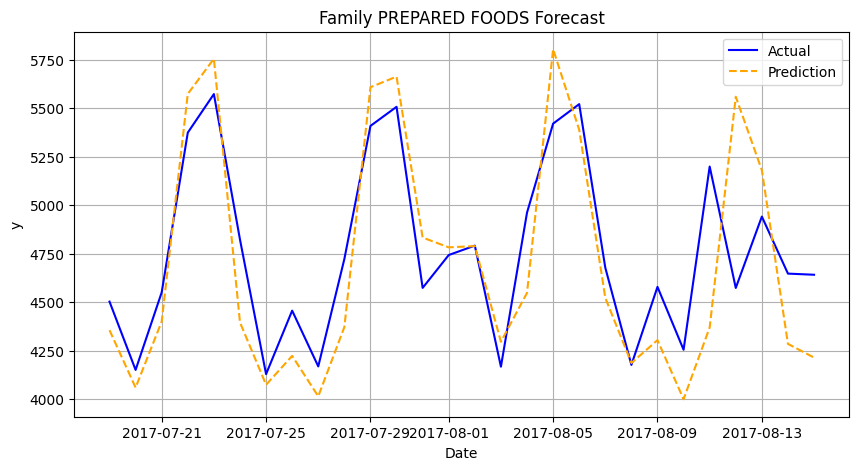

In [46]:
# Example: plot for one family
selected_family = family_list[i]
plot_forecast(
    pred_df=pred_df,
    date_col=cfg["data"]["date_col"],
    actual_col="y",
    pred_col="prediction",
    group_cols=['family'], #cfg["data"]["group_cols"],
    series_id={"family": selected_family},
    title=f"Family {selected_family} Forecast"
)
i +=1


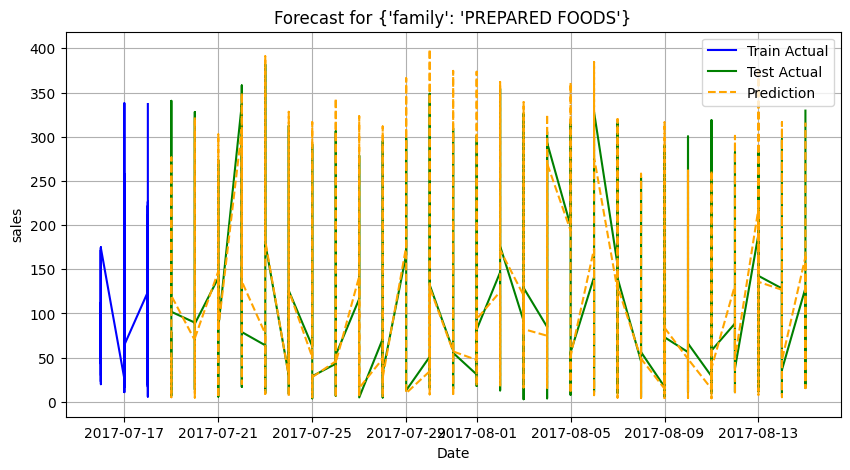

In [49]:
plot_train_test_forecast(train, test, pred,
                         date_col=cfg["data"]["date_col"],
                         target_col="sales",
                         pred_col="prediction",
                         group_cols=cfg["data"]["group_cols"],
                         series_id={"family": selected_family}, last_n_train=120)

i += 1

In [50]:
run_forecast(df, cfg=cfg)

NameError: name 'df' is not defined

In [3]:
agg_cols = ['family', 'store_nbr', 'state', 'city', 'type', 'cluster'] # there is one store per city and type and cluster so adding those feature is redundant
agg_cols = ['family', 'store_nbr'] # there is one store per city and type and cluster so adding those feature is redundant

# agg_cols = ['family']

df_agg = aggregate_to_granularity(
    df=df,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    agg="sum",  # sales are additive
    # extra_numeric_aggs={"dcoilwtico": "mean"}  # optional
)
print(df_agg.count())
df_agg.show(2)

df_feat = build_features(
    df=df_agg,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    lags=[1, 7, 14, 28],
    mas=[7, 28],
    # add_time_signals=cfg["features"]["add_time_signals"]
)
df_feat.show(10)
print(df_feat.count())
# df_feat.sort(agg_cols + ["date"]).select(agg_cols + ['date', 'sales', 'dcoilwtico', 'lag_1', 'lag_2']).show(10)

3000888


+---------+---------+----------+-----+
|   family|store_nbr|      date|sales|
+---------+---------+----------+-----+
|    DAIRY|        1|2013-01-15|357.0|
|BEVERAGES|       39|2013-01-17|512.0|
+---------+---------+----------+-----+
only showing top 2 rows


+----------+---------+----------+-----+-----+-----+------+------+------------------+------------------+---+---+----------+-----+----+
|    family|store_nbr|      date|sales|lag_1|lag_7|lag_14|lag_28|              ma_7|             ma_28|dow|dom|weekofyear|month|year|
+----------+---------+----------+-----+-----+-----+------+------+------------------+------------------+---+---+----------+-----+----+
|AUTOMOTIVE|       10|2013-01-29|  1.0|  1.0|  1.0|   0.0|   0.0|1.1428571428571428|              1.75|  3| 29|         5|    1|2013|
|AUTOMOTIVE|       10|2013-01-30|  3.0|  1.0|  2.0|   6.0|   3.0|1.2857142857142858|              1.75|  4| 30|         5|    1|2013|
|AUTOMOTIVE|       10|2013-01-31|  3.0|  3.0|  0.0|   0.0|   2.0|1.7142857142857142|1.7857142857142858|  5| 31|         5|    1|2013|
|AUTOMOTIVE|       10|2013-02-01|  1.0|  3.0|  0.0|   1.0|   2.0|1.8571428571428572|              1.75|  6|  1|         5|    2|2013|
|AUTOMOTIVE|       10|2013-02-02|  4.0|  1.0|  3.0|   1.0|   0

2950992


In [51]:
from icecream import ic

d, a, f, s, m, e = (
    cfg["data"],
    cfg.get("aggregation", {}),
    cfg["features"],
    cfg["split"],
    cfg["model"],
    cfg["evaluation"],
)

df_agg = aggregate_to_granularity(
    df_raw,
    d["date_col"],
    d["target_col"],
    d["group_cols"],
    agg=a.get("target_agg", "sum"),
    extra_numeric_aggs=a.get("extra_numeric_aggs"),
)
ic()

bt = rolling_backtest(
    df_agg,
    d["date_col"],
    d["target_col"],
    d["group_cols"],
    feature_params={
        "lags": f["lags"],
        "mas": f["mas"],
        "add_time_signals": f["add_time_signals"],
        "freq": d.get("freq", "D"),
    },
    model_type=m["type"],
    model_params=m["params"],
    folds=e["backtest"]["folds"],
    fold_horizon=e["backtest"]["fold_horizon"],
    step=e["backtest"]["step"],
    mase_seasonality=e["mase_seasonality"],
)


25/12/25 20:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1000.9 KiB
25/12/25 20:24:21 WARN DAGScheduler: Broadcasting large task binary with size 1010.1 KiB
25/12/25 20:24:21 WARN DAGScheduler: Broadcasting large task binary with size 1014.4 KiB
25/12/25 20:24:21 WARN DAGScheduler: Broadcasting large task binary with size 1014.9 KiB
25/12/25 20:24:21 WARN DAGScheduler: Broadcasting large task binary with size 1015.9 KiB
25/12/25 20:24:22 WARN DAGScheduler: Broadcasting large task binary with size 1016.8 KiB
25/12/25 20:24:22 WARN DAGScheduler: Broadcasting large task binary with size 1019.1 KiB
25/12/25 20:24:22 WARN DAGScheduler: Broadcasting large task binary with size 1023.8 KiB
25/12/25 20:24:22 WARN DAGScheduler: Broadcasting large task binary with size 1033.3 KiB
25/12/25 20:24:22 WARN DAGScheduler: Broadcasting large task binary with size 1037.1 KiB
25/12/25 20:24:23 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB
25/12/25 20:24:23 WAR

In [53]:
bt.show()

+------------------+-------------------+------------------+---------+----+
|             sMAPE|              wMAPE|              MASE|    level|fold|
+------------------+-------------------+------------------+---------+----+
|              NULL|               NULL|              NULL|portfolio|   0|
|              NULL|               NULL|              NULL|portfolio|   1|
|0.6507243859703609|0.15482977188247243|0.7561426323651654|portfolio|   2|
|0.6394424615820615|0.14674055910715758|0.7237052411777664|portfolio|   3|
+------------------+-------------------+------------------+---------+----+



In [31]:
# agg_cols = ['family', 'store_nbr']
agg_cols = ['family']

df_agg = aggregate_to_granularity(
    df=df,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    agg="sum",  # sales are additive
    # extra_numeric_aggs={"price": "mean", "promo_spend": "sum"}  # optional
)

df_feat = build_features(
    df=df_agg,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    lags=[1,2],
    mas=[1,2],
    # add_time_signals=cfg["features"]["add_time_signals"]
)
print(df_feat.count())
df_feat.sort(agg_cols + ["date"]).select(agg_cols + ['date', 'sales', 'lag_1', 'lag_2']).show(10)
df_feat.show(10)

55506
+----------+----------+-----+-----+-----+
|    family|      date|sales|lag_1|lag_2|
+----------+----------+-----+-----+-----+
|AUTOMOTIVE|2013-01-03|161.0|255.0|  0.0|
|AUTOMOTIVE|2013-01-04|169.0|161.0|255.0|
|AUTOMOTIVE|2013-01-05|342.0|169.0|161.0|
|AUTOMOTIVE|2013-01-06|360.0|342.0|169.0|
|AUTOMOTIVE|2013-01-07|189.0|360.0|342.0|
|AUTOMOTIVE|2013-01-08|229.0|189.0|360.0|
|AUTOMOTIVE|2013-01-09|164.0|229.0|189.0|
|AUTOMOTIVE|2013-01-10|164.0|164.0|229.0|
|AUTOMOTIVE|2013-01-11|162.0|164.0|164.0|
|AUTOMOTIVE|2013-01-12|280.0|162.0|164.0|
+----------+----------+-----+-----+-----+
only showing top 10 rows
+----------+----------+-----+-----+-----+-----+-----+---+---+----------+-----+----+
|    family|      date|sales|lag_1|lag_2| ma_1| ma_2|dow|dom|weekofyear|month|year|
+----------+----------+-----+-----+-----+-----+-----+---+---+----------+-----+----+
|AUTOMOTIVE|2013-01-03|161.0|255.0|  0.0|161.0|208.0|  5|  3|         1|    1|2013|
|AUTOMOTIVE|2013-01-04|169.0|161.0|255.0|169.

In [36]:
train, test = train_test_split(df=df_feat, date_col='date', group_cols=agg_cols, mode='horizon', test_horizon=28)
train.show(2)
test.show(2)

+----------+---------+----------+-----+----------+-----+-----+----+----+---+---+----------+-----+----+
|    family|store_nbr|      date|sales|dcoilwtico|lag_1|lag_2|ma_1|ma_2|dow|dom|weekofyear|month|year|
+----------+---------+----------+-----+----------+-----+-----+----+----+---+---+----------+-----+----+
|AUTOMOTIVE|       10|2013-01-03|  2.0|     92.97|  3.0|  0.0| 2.0| 2.5|  5|  3|         1|    1|2013|
|AUTOMOTIVE|       10|2013-01-04|  2.0|     93.12|  2.0|  3.0| 2.0| 2.0|  6|  4|         1|    1|2013|
+----------+---------+----------+-----+----------+-----+-----+----+----+---+---+----------+-----+----+
only showing top 2 rows


+----------+---------+----------+-----+----------+-----+-----+----+----+---+---+----------+-----+----+
|    family|store_nbr|      date|sales|dcoilwtico|lag_1|lag_2|ma_1|ma_2|dow|dom|weekofyear|month|year|
+----------+---------+----------+-----+----------+-----+-----+----+----+---+---+----------+-----+----+
|AUTOMOTIVE|       10|2017-07-19|  0.0|      47.1|  0.0|  0.0| 0.0| 0.0|  4| 19|        29|    7|2017|
|AUTOMOTIVE|       10|2017-07-20|  1.0|     46.73|  0.0|  0.0| 1.0| 0.5|  5| 20|        29|    7|2017|
+----------+---------+----------+-----+----------+-----+-----+----+----+---+---+----------+-----+----+
only showing top 2 rows


In [22]:
agg_cols = ['family', 'family']
# agg_cols = ['family']

df_agg = aggregate_to_granularity(
    df=df,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    agg="sum",  # sales are additive
    # extra_numeric_aggs={"price": "mean", "promo_spend": "sum"}  # optional
)

df_feat = build_features(
    df=df_agg,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    lags=[1,2],
    mas=[1,2],
    # add_time_signals=cfg["features"]["add_time_signals"]
)
print(df_feat.count())
df_feat.sort(agg_cols + ["date"]).select(agg_cols + ['date', 'sales', 'lag_1', 'lag_2']).show(10)

55506
+----------+----------+----------+-----+-----+-----+
|    family|    family|      date|sales|lag_1|lag_2|
+----------+----------+----------+-----+-----+-----+
|AUTOMOTIVE|AUTOMOTIVE|2013-01-03|161.0|255.0|  0.0|
|AUTOMOTIVE|AUTOMOTIVE|2013-01-04|169.0|161.0|255.0|
|AUTOMOTIVE|AUTOMOTIVE|2013-01-05|342.0|169.0|161.0|
|AUTOMOTIVE|AUTOMOTIVE|2013-01-06|360.0|342.0|169.0|
|AUTOMOTIVE|AUTOMOTIVE|2013-01-07|189.0|360.0|342.0|
|AUTOMOTIVE|AUTOMOTIVE|2013-01-08|229.0|189.0|360.0|
|AUTOMOTIVE|AUTOMOTIVE|2013-01-09|164.0|229.0|189.0|
|AUTOMOTIVE|AUTOMOTIVE|2013-01-10|164.0|164.0|229.0|
|AUTOMOTIVE|AUTOMOTIVE|2013-01-11|162.0|164.0|164.0|
|AUTOMOTIVE|AUTOMOTIVE|2013-01-12|280.0|162.0|164.0|
+----------+----------+----------+-----+-----+-----+
only showing top 10 rows


In [ ]:
dfx = build_features(df, "date", "sales", ["family", "store_nbr"], lags=[1, 2], mas=[1])
print(dfx.count())
dfx.sort(["family", "store_nbr", "date"]).select(['family', 'store_nbr', 'date', 'sales', 'lag_1', 'lag_2']).show(10)

2997324


+----------+---------+----------+-----+-----+-----+
|    family|store_nbr|      date|sales|lag_1|lag_2|
+----------+---------+----------+-----+-----+-----+
|AUTOMOTIVE|        1|2013-01-03|  3.0|  2.0|  0.0|
|AUTOMOTIVE|        1|2013-01-04|  3.0|  3.0|  2.0|
|AUTOMOTIVE|        1|2013-01-05|  5.0|  3.0|  3.0|
|AUTOMOTIVE|        1|2013-01-06|  2.0|  5.0|  3.0|
|AUTOMOTIVE|        1|2013-01-07|  0.0|  2.0|  5.0|
|AUTOMOTIVE|        1|2013-01-08|  2.0|  0.0|  2.0|
|AUTOMOTIVE|        1|2013-01-09|  2.0|  2.0|  0.0|
|AUTOMOTIVE|        1|2013-01-10|  2.0|  2.0|  2.0|
|AUTOMOTIVE|        1|2013-01-11|  3.0|  2.0|  2.0|
|AUTOMOTIVE|        1|2013-01-12|  2.0|  3.0|  2.0|
+----------+---------+----------+-----+-----+-----+
only showing top 10 rows


In [23]:
dfx = build_features(df, "date", "sales", ["family"], lags=[1, 2], mas=[1])
print(dfx.count())
dfx.sort(["family", "store_nbr", "date"]).select(['family', 'store_nbr', 'date', 'sales', 'lag_1', 'lag_2']).show(10)

3000822


+----------+---------+----------+-----+-----+-----+
|    family|store_nbr|      date|sales|lag_1|lag_2|
+----------+---------+----------+-----+-----+-----+
|AUTOMOTIVE|        1|2013-01-01|  0.0|  0.0|  0.0|
|AUTOMOTIVE|        1|2013-01-02|  2.0| 11.0|  0.0|
|AUTOMOTIVE|        1|2013-01-03|  3.0|  0.0|  5.0|
|AUTOMOTIVE|        1|2013-01-04|  3.0|  0.0|  1.0|
|AUTOMOTIVE|        1|2013-01-05|  5.0|  0.0|  6.0|
|AUTOMOTIVE|        1|2013-01-06|  2.0|  7.0|  5.0|
|AUTOMOTIVE|        1|2013-01-07|  0.0|  5.0|  7.0|
|AUTOMOTIVE|        1|2013-01-08|  2.0|  2.0| 14.0|
|AUTOMOTIVE|        1|2013-01-09|  2.0|  7.0|  0.0|
|AUTOMOTIVE|        1|2013-01-10|  2.0| 12.0|  3.0|
+----------+---------+----------+-----+-----+-----+
only showing top 10 rows


In [ ]:
# Load config from YAML or dict
import yaml, json
cfg = yaml.safe_load(open("forecast_config.yaml"))

out = run_forecast(df_feat, cfg)

display(out["predictions"])         # per-group predictions on test window
# display(out["metrics_portfolio"])   # wMAPE, sMAPE, MASE overall
# display(out["metrics_by_series"])   # same metrics by series
# display(out["backtest"])            # rolling-origin backtest summary (if enabled)
